<img src="https://static.wixstatic.com/media/66c28f_db7a1ba3e35b4b17a6688472c889b7bf~mv2_d_2777_1254_s_2.png/v1/fill/w_710,h_320,al_c,q_85,usm_0.66_1.00_0.01/logo_yellow_white.webp" width=1000, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

# Text Summarization

Всем привет! Сегодня мы познакомимся с задачей суммаризации текста на примере генерации "сжатых" новостей. Рассмотрим некоторые базовые решения и познакомимся с архитектурами нейросетей для решения задачи.
Датасет: gazeta.ru


`Ноутбук создан на основе семинара Гусева Ильи на кафедре компьютерной лингвистики ABBYY МФТИ.`

Загрузим датасет и необходимые библиотеки

In [ ]:
!wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

In [ ]:
!pip -q install razdel networkx pymorphy2 nltk rouge==0.3.1 summa 

     |████████████████████████████████| 55 kB 1.6 MB/s 
     |████████████████████████████████| 54 kB 1.4 MB/s 
     |████████████████████████████████| 8.2 MB 5.2 MB/s 


## Dataset

Посмотрим на то, как устроен датасет

In [ ]:
!head -n 1 gazeta_train.txt
!cat gazeta_train.txt | wc -l
!cat gazeta_val.txt | wc -l
!cat gazeta_test.txt | wc -l

{"url": "https://www.gazeta.ru/financial/2011/11/30/3852658.shtml", "text": "«По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменение прогноза было ожидаемо: по расчетам Центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «После октябрьских данных Минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожида

In [ ]:
import json
import random

def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r") as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle
    return records

In [ ]:
train_records = read_gazeta_records("gazeta_train.txt")
val_records = read_gazeta_records("gazeta_val.txt")
test_records = read_gazeta_records("gazeta_test.txt")

In [ ]:
len(train_records), len(val_records), len(test_records)

(52400, 5265, 5770)

In [ ]:
train_records[0]

{'url': 'https://www.gazeta.ru/financial/2011/11/30/3852658.shtml',
 'text': '«По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменение прогноза было ожидаемо: по расчетам Центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «После октябрьских данных Минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожид

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge

def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Ref:", references[-1])
    print("Hyp:", predictions[-1])

    if metric in ("bleu", "all"):
        print("BLEU: ", corpus_bleu([[r] for r in references], predictions))
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(predictions, references, avg=True)
        print("ROUGE: ", scores)

## Extractive RNN

### BPE
Для начала сделаем BPE токенизацию

In [ ]:
!pip install youtokentome

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 7.4 MB/s 


In [ ]:
import youtokentome as yttm

def train_bpe(records, model_path, model_type="bpe", vocab_size=10000, lower=True):
    temp_file_name = "temp.txt"
    with open(temp_file_name, "w") as temp:
        for record in records:
            text, summary = record['text'], record['summary']
            if lower:
                summary = summary.lower()
                text = text.lower()
            if not text or not summary:
                continue
            temp.write(text + "\n")
            temp.write(summary + "\n")
    yttm.BPE.train(data=temp_file_name, vocab_size=vocab_size, model=model_path)

train_bpe(train_records, "BPE_model.bin")

In [ ]:
!head -n 2 temp.txt

«по итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. при этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «интерфаксу» замминистра экономического развития андрей клепач. официальные прогнозы по выводу капитала из россии становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре минэкономразвития назвал цифру $50 млрд, в начале ноября центробанк пересмотрел оценку до $70 млрд. очередное изменение прогноза было ожидаемо: по расчетам центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «после октябрьских данных минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожидать серьезного замедления оттока капитала на непонятно каких причинах», — гово

### Словарь
Составим словарь для индексации токенов

In [ ]:
bpe_processor = yttm.BPE('BPE_model.bin')
vocabulary = bpe_processor.vocab()

In [ ]:
len(vocabulary)

10000

In [ ]:
type(vocabulary), vocabulary[0:10000:1000]

(list,
 ['<PAD>',
  'от',
  '▁поясни',
  '▁спец',
  '▁уси',
  '▁медведев',
  'дзе',
  'гали',
  '▁остави',
  '▁интри'])

In [ ]:
vocabulary[:5]

['<PAD>', '<UNK>', '<BOS>', '<EOS>', '▁']

### Кэш oracle summary
Закэшируем oracle summary, чтобы не пересчитывать их каждый раз

In [ ]:
from rouge import Rouge
import razdel
from tqdm.notebook import tqdm

import copy

In [ ]:
def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    '''
    Жадное построение oracle summary
    '''
    gold_summary = gold_summary.lower() if lower else gold_summary
    # Делим текст на предложения
    sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
    n_sentences = len(sentences)
    oracle_summary_sentences = set()
    
    score = -1.0
    summaries = []
    for _ in range(n_sentences):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)
            # Добавляем какое-то предложения к уже существующему summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])
            # Считаем метрики
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))
        # Если получилось улучшить метрики с добавлением какого-либо предложения, то пробуем добавить ещё
        # Иначе на этом заканчиваем
        best_summary_score, best_summary_sentences = max(summaries)
        if best_summary_score <= score:
            break
        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score
    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])
    return oracle_summary, oracle_summary_sentences

def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)['rouge-2']['f']

def add_oracle_summary_to_records(records, max_sentences=30, lower=True, nrows=1000):
    rouge = Rouge()
    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break
        text = record["text"]
        summary = record["summary"]

        summary = summary.lower() if lower else summary
        sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
        oracle_summary, sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge),
                                                                         lower=lower, max_sentences=max_sentences)
        record["sentences"] = sentences
        record["oracle_sentences"] = list(sentences_indicies)
        record["oracle_summary"] = oracle_summary

    return records[:nrows]

ext_train_records = add_oracle_summary_to_records(train_records, nrows=2048)
ext_val_records = add_oracle_summary_to_records(val_records, nrows=256)
ext_test_records = add_oracle_summary_to_records(test_records, nrows=256)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Чтобы сохранять результаты в свою папку на Google disk
%cd ./drive/MyDrive/DLS_NLP/7w_summarization/

/content/drive/MyDrive/DLS_NLP/7w_summarization


In [ ]:
# сохраним результаты oracle summary, чтобы не повторять процедуру
import pickle
with open('ext_train_records.pickle', 'wb') as f:
    pickle.dump(ext_train_records, f)

with open('ext_val_records.pickle', 'wb') as f:
    pickle.dump(ext_val_records, f)

with open('ext_test_records.pickle', 'wb') as f:
    pickle.dump(ext_test_records, f)

In [ ]:
# загрузим oracle summary
import pickle

with open('ext_train_records.pickle', 'rb') as handle:
    ext_train_records = pickle.load(handle)

with open('ext_val_records.pickle', 'rb') as handle:
    ext_val_records = pickle.load(handle)

with open('ext_test_records.pickle', 'rb') as handle:
    ext_test_records = pickle.load(handle)

In [ ]:
len(ext_train_records), len(ext_val_records), len(ext_test_records)

(2048, 256, 256)

In [ ]:
ext_train_records[0]['summary'], ext_train_records[0]['oracle_summary'], ext_train_records[0]['oracle_sentences']

('В 2011 году из России уйдет $80 млрд, считают в Минэкономразвития. Менее месяца назад Центробанк давал оценку $70 млрд, повысив первоначальный прогноз вдвое. Отток капитала из страны усиливается из-за кризиса в Европе, а в декабре российским компаниям выплачивать внешние долги. На движение капитала повлияли и выборы: несмотря на их предсказуемость, бизнес хочет ясности с перестановками в правительстве.',
 'официальные прогнозы по выводу капитала из россии становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре минэкономразвития назвал цифру $50 млрд, в начале ноября центробанк пересмотрел оценку до $70 млрд. прогнозируемый минэкономразвития отток капитала — один из самых высоких за последние 20 лет. главный фактор ускорения оттока капитала в 2011 году — нестабильность на внешних финансовых рынках и рост опасений относительно второй волны рецессии. «бизнесу важно не только, кто будет президентом, он ждет ясности с перестановками в п

### Составление батчей

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import random
import math
import razdel
import torch
import numpy as np
from rouge import Rouge


class BatchIterator():
    def __init__(self, records, vocabulary, batch_size, bpe_processor, shuffle=True, lower=True, max_sentences=30, max_sentence_length=80, device=torch.device('cpu')):
        self.records = records
        self.num_samples = len(records)
        self.batch_size = batch_size
        self.bpe_processor = bpe_processor
        self.shuffle = shuffle
        self.batches_count = int(math.ceil(self.num_samples / batch_size))
        self.lower = lower
        self.rouge = Rouge()
        self.vocabulary = vocabulary
        self.max_sentences = max_sentences
        self.max_sentence_length = max_sentence_length
        self.device = device
        
    def __len__(self):
        return self.batches_count
    
    def __iter__(self):
        indices = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indices)

        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            batch_indices = indices[start:end]

            batch_inputs = []
            batch_outputs = []
            max_sentence_length = 0
            max_sentences = 0
            batch_records = []

            for data_ind in batch_indices:
                
                record = self.records[data_ind]
                batch_records.append(record)
                text = record["text"]
                summary = record["summary"]
                summary = summary.lower() if self.lower else summary

                if "sentences" not in record:
                    sentences = [sentence.text.lower() if self.lower else sentence.text for sentence in razdel.sentenize(text)][:self.max_sentences]
                else:
                    sentences = record["sentences"]
                max_sentences = max(len(sentences), max_sentences)
                
                # номера предложений, которые в нашем саммари
                if "oracle_sentences" not in record:
                    calc_score = lambda x, y: calc_single_score(x, y, self.rouge)
                    sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=calc_score, lower=self.lower, max_sentences=self.max_sentences)[1]
                else:   
                    sentences_indicies = record["oracle_sentences"]
                
                # inputs - индексы слов в предложении
                inputs = [bpe_processor.encode(sentence)[:self.max_sentence_length] for sentence in sentences]
                max_sentence_length = max(max_sentence_length, max([len(tokens) for tokens in inputs]))
                
                # получение метки класса предложения
                outputs = [int(i in sentences_indicies) for i in range(len(sentences))]
                batch_inputs.append(inputs)
                batch_outputs.append(outputs)

            tensor_inputs = torch.zeros((self.batch_size, max_sentences, max_sentence_length), dtype=torch.long, device=self.device)
            # we add index 2 for padding
            # YOUR CODE
            tensor_outputs = torch.tensor([2], dtype=torch.float32, device=self.device).repeat(self.batch_size, max_sentences)

            for i, inputs in enumerate(batch_inputs):
                for j, sentence_tokens in enumerate(inputs):
                    tensor_inputs[i][j][:len(sentence_tokens)] = torch.tensor(sentence_tokens, dtype=torch.int64)

            for i, outputs in enumerate(batch_outputs):
                tensor_outputs[i][:len(outputs)] = torch.LongTensor(outputs)

            tensor_outputs = tensor_outputs.long()
            yield {
                'inputs': tensor_inputs,
                'outputs': tensor_outputs,
                'records': batch_records
            }

In [ ]:
train_iterator = BatchIterator(ext_train_records, vocabulary, 32, bpe_processor, device=device)
val_iterator = BatchIterator(ext_val_records, vocabulary, 32, bpe_processor, device=device)
test_iterator = BatchIterator(ext_test_records, vocabulary, 32, bpe_processor, device=device)

## Extractor -  SummaRuNNer
 https://arxiv.org/pdf/1611.04230.pdf


### Homework

* В данной реализации в `outputs` в качестве padding используется индекс 0. Измените в функции \_\_iter__ индекс padding, чтобы он не совпадал с классом 0 или 1, например, 2. **Сделано. См. BatchIterator**
* В качестве criterion используйте `CrossEntropyLoss`вместо `BCEWithLogitsLoss`
* Из-за смены criterion, вы уже должны подавать на вход criterion ни одно число, а logits для каждого класса. Перед подачей logits вы можете отфильтровать предсказания для класса padding. В этом пункте вам придется изменять файл `train_model.py`, а именно функциии `train` и `evaluate`. **Сделано. См. `train_model.py`**
* Используйте два варианта обучения: c весами в `CrossEntropyLoss` и без. **Сделано. См. функцию `model_train`**
* Также сравните `inference`, когда вы ранжируете logits, и когды вы выбирате предложения, у котрых logits > 0, в двух вариантах обучения. **Сделано. См. функцию `inference_summarunner`**
* Реализуйте дополнительно характеристику предложения `novelty`. Как влияет добавление `novelty` на качество summary? **Сделано. См. функцию `class SentenceTaggerRNN`**
* Постарайтесь улучшить качество модели, полученной на семинаре: $BLEU \approx 0.45$ **См. раздел Выводы**

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack

class SentenceEncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, n_layers=3, dropout=0.3, bidirectional=True):
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.embedding_dim = embedding_dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding_layer = nn.Embedding(input_size, embedding_dim)
        self.rnn_layer = nn.LSTM(embedding_dim, hidden_size, n_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, inputs, hidden=None):
        embedded = self.dropout_layer(self.embedding_layer(inputs))
        outputs, _ = self.rnn_layer(embedded, hidden)
        sentences_embeddings = torch.mean(outputs, 1)
        # [batch_size, hidden_size]
        return sentences_embeddings

class SentenceTaggerRNN(nn.Module):
    def __init__(self,
                 vocabulary_size,
                 use_content=True,
                 use_salience=True,
                 use_novelty=True,
                 token_embedding_dim=200,
                 sentence_encoder_hidden_size=400,
                 hidden_size=400,
                 bidirectional=True,
                 sentence_encoder_n_layers=2,
                 sentence_encoder_dropout=0.2,
                 sentence_encoder_bidirectional=True,
                 n_layers=2,
                 dropout=0.2):
        
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.sentence_encoder = SentenceEncoderRNN(vocabulary_size, token_embedding_dim,
                                                   sentence_encoder_hidden_size, sentence_encoder_n_layers, 
                                                   sentence_encoder_dropout, sentence_encoder_bidirectional)
        
        self.rnn_layer = nn.LSTM(sentence_encoder_hidden_size, hidden_size, n_layers, dropout=dropout,
                           bidirectional=bidirectional, batch_first=True)
        
        self.dropout_layer = nn.Dropout(dropout)
        self.content_linear_layer = nn.Linear(hidden_size * 2, 1)
        self.document_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.salience_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.novelty_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.tanh_layer = nn.Tanh()
        self.sigmoid_layer = nn.Sigmoid()

        self.use_content = use_content
        self.use_salience = use_salience
        self.use_novelty = use_novelty

    def forward(self, inputs, hidden=None):
        # parameters of the probability
        content = 0
        salience = 0
        novelty = 0

        # [batch_size, seq num, seq_len]
        batch_size = inputs.size(0)
        sentences_count = inputs.size(1)
        tokens_count = inputs.size(2)
        inputs = inputs.reshape(-1, tokens_count)
        # [batch_size * seq num, seq_len]

        embedded_sentences = self.sentence_encoder(inputs)
        embedded_sentences = self.dropout_layer(embedded_sentences.reshape(batch_size, sentences_count, -1))
        # [batch_size *  seq num, seq_len, hidden_size*2] -> [batch_size, seq num, hidden_size*2]

        outputs, _ = self.rnn_layer(embedded_sentences, hidden)
        # [batch_size, seq num, hidden_size*2]

        document_embedding = self.tanh_layer(self.document_linear_layer(torch.mean(outputs, 1)))
        # [batch_size, hidden_size*2]

        #predictions (if all of use False)
        predictions = torch.zeros((batch_size, sentences_count), dtype=torch.float32, device=device)

        # W * h^T
        if self.use_content:
            content = self.content_linear_layer(outputs).squeeze(2) # 1-representation
            # [batch_size, seq num]
            predictions += content

        # h^T * W * d
        if self.use_salience:
            salience = torch.bmm(outputs, self.salience_linear_layer(document_embedding).unsqueeze(2)).squeeze(2) # 2-representation
            # [batch_size, seq num, hidden_size*2] * [batch_size, hidden_size*2, 1] = [batch_size, seq num, ]
            predictions += salience

        if self.use_novelty:
            # at every step add novelty to prediction of the sentence
            # predictions = content + salience (if use_content and use_salience)
            
            # 0) initialize summary_representation and novelty by zeros
            s = torch.zeros((batch_size, self.hidden_size * 2), dtype=torch.float32, device=device)
            novelty = torch.zeros((batch_size, sentences_count), dtype=torch.float32, device=device)

            for sentence_num in range(sentences_count):

                # 1) take sentence_num_state from outputs(representation of the sentence with number sentence_num)
                sentence_num_state = outputs[:, sentence_num, :]  # [batch_size, hidden_size*2]
                
                # 2) calculate novelty for current sentence
                  # W * tanh(s)
                nov_linear = self.novelty_linear_layer(self.tanh_layer(s)).unsqueeze(2) # [batch_size, hidden_size*2, 1]
                  # h^T * W * tanh(s)
                novelty[:, sentence_num] = (-1) * torch.bmm(sentence_num_state.unsqueeze(1), nov_linear).flatten() 
                # [batch_size, 1, hidden_size*2] * [batch_size, hidden_size*2, 1] = [batch_size, 1, ]

                # 3) add novelty to predictions
                predictions[:, sentence_num] += novelty[:, sentence_num]

                # 4) calculcate probability for current sentence
                probabilities = self.sigmoid_layer(predictions[:, sentence_num]) #[batch_size]

                # 5) add sentence_num_state with the weight which is equal to probability to summary_representation\
                s += sentence_num_state * probabilities.reshape(-1, 1)  #[batch_size, self.hidden_size * 2]

        return predictions

## Model
$P\left(y_{j} = 1 \mid \mathbf{h}_{j}, \mathbf{s}_{j}, \mathbf{d}\right)=\sigma\left(W_{c} \mathbf{h}_{j} + \mathbf{h}_{j}^{T} W_{s} \mathbf{d} - \mathbf{h}_{j}^{T} W_{r} \mathbf{tanh}(\mathbf{s}_{j})\right)$
--------------------
$ \mathbf{s}_{j} = \sum_{i=1}^{j-1}\mathbf{h}_{i}P\left(y_{i} = 1 \mid \mathbf{h}_{i}, \mathbf{s}_{i}, \mathbf{d}\right)$

In [ ]:
vocab_size = len(vocabulary)
model = SentenceTaggerRNN(vocab_size).to(device)

params_count = np.sum([p.numel() for p in model.parameters() if p.requires_grad])
print("Trainable params: {}".format(params_count))

Trainable params: 6014401


In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")

sentence_encoder.embedding_layer.weight: 2000000
sentence_encoder.rnn_layer.weight_ih_l0: 160000
sentence_encoder.rnn_layer.weight_hh_l0: 160000
sentence_encoder.rnn_layer.bias_ih_l0: 800
sentence_encoder.rnn_layer.bias_hh_l0: 800
sentence_encoder.rnn_layer.weight_ih_l0_reverse: 160000
sentence_encoder.rnn_layer.weight_hh_l0_reverse: 160000
sentence_encoder.rnn_layer.bias_ih_l0_reverse: 800
sentence_encoder.rnn_layer.bias_hh_l0_reverse: 800
sentence_encoder.rnn_layer.weight_ih_l1: 320000
sentence_encoder.rnn_layer.weight_hh_l1: 160000
sentence_encoder.rnn_layer.bias_ih_l1: 800
sentence_encoder.rnn_layer.bias_hh_l1: 800
sentence_encoder.rnn_layer.weight_ih_l1_reverse: 320000
sentence_encoder.rnn_layer.weight_hh_l1_reverse: 160000
sentence_encoder.rnn_layer.bias_ih_l1_reverse: 800
sentence_encoder.rnn_layer.bias_hh_l1_reverse: 800
rnn_layer.weight_ih_l0: 320000
rnn_layer.weight_hh_l0: 160000
rnn_layer.bias_ih_l0: 800
rnn_layer.bias_hh_l0: 800
rnn_layer.weight_ih_l0_reverse: 320000
rnn_la

Сохраним train_model.py для возможности его менять и последующего вызова на Google-disk

In [ ]:
# !gdown https://drive.google.com/uc?id=1MiS_iczALcyF7zGDPY6niyeD82P0_PBH -O train_model.py

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1MiS_iczALcyF7zGDPY6niyeD82P0_PBH 



Перенесем сюда функции из train_model.py для наглядности(но использоваться будем модуль train_model.py

In [ ]:
# All functions from train_model.py (don't run this cell)

import matplotlib
import time
import math
import torch
import re
import razdel
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
from IPython.display import clear_output

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        optimizer.zero_grad()
        
        inputs = batch['inputs']
        target = batch['outputs']
        logits = model(inputs)  # for 1 class
        # logits for 0 class should be = -logits, because sigmoid(-logits) + sigmoid(logits) = 1
        outputs = torch.cat([-logits.unsqueeze(1), logits.unsqueeze(1)], dim=1) #[batch_size, 2, seq_num]
        loss = criterion(outputs, target)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        history.append(loss.item())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    history = []
    
    with torch.no_grad():    
        for i, batch in enumerate(iterator):
          inputs = batch['inputs']
          target = batch['outputs']
          logits = model(inputs)  # for 1 class
          # logits for 0 class should be = -logits, because sigmoid(-logits) + sigmoid(logits) = 1
          outputs = torch.cat([-logits.unsqueeze(1), logits.unsqueeze(1)], dim=1) #[batch_size, 2, seq_num]
          loss = criterion(outputs, target)            
          epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def train_with_logs(model, train_iterator, valid_iterator, optimizer, criterion, N_EPOCHS, CLIP):
    train_history = []
    valid_history = [] 
    best_valid_loss = float('inf')
    
    for epoch in range(N_EPOCHS):        
        start_time = time.time()        
        train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
        valid_loss = evaluate(model, valid_iterator, criterion)        
        end_time = time.time()   

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best-val-model.pt')
        
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        
def punct_detokenize(text):
    text = text.strip()
    punctuation = ",.!?:;%"
    closing_punctuation = ")]}"
    opening_punctuation = "([}"
    for ch in punctuation + closing_punctuation:
        text = text.replace(" " + ch, ch)
    for ch in opening_punctuation:
        text = text.replace(ch + " ", ch)
    res = [r'"\s[^"]+\s"', r"'\s[^']+\s'"]
    for r in res:
        for f in re.findall(r, text, re.U):
            text = text.replace(f, f[0] + f[2:-2] + f[-1])
    text = text.replace("' s", "'s").replace(" 's", "'s")
    text = text.strip()
    return text


def postprocess(ref, hyp, is_multiple_ref=False, detokenize_after=False, tokenize_after=True):
    if is_multiple_ref:
        reference_sents = ref.split(" s_s ")
        decoded_sents = hyp.split("s_s")
        hyp = [w.replace("<", "&lt;").replace(">", "&gt;").strip() for w in decoded_sents]
        ref = [w.replace("<", "&lt;").replace(">", "&gt;").strip() for w in reference_sents]
        hyp = " ".join(hyp)
        ref = " ".join(ref)
    ref = ref.strip()
    hyp = hyp.strip()
    if detokenize_after:
        hyp = punct_detokenize(hyp)
        ref = punct_detokenize(ref)
    if tokenize_after:
        hyp = hyp.replace("@@UNKNOWN@@", "<unk>")
        hyp = " ".join([token.text for token in razdel.tokenize(hyp)])
        ref = " ".join([token.text for token in razdel.tokenize(ref)])
    return ref, hyp

In [ ]:
# compute class weights
PAD_IDX = 2

zeros = 0
ones = 0

for batch in train_iterator:
    outputs = batch['outputs']
    zeros += (outputs == 0).sum().item()
    ones += (outputs == 1).sum().item()

zeros_weight = 1 - zeros / (zeros + ones)
ones_weight = 1 - ones / (zeros + ones)

weights = torch.tensor([zeros_weight, ones_weight], dtype=torch.float32, device=device)

In [ ]:
weights

tensor([0.0769, 0.9231], device='cuda:0')

In [ ]:
import train_model
import imp 
imp.reload(train_model)
from train_model import train_with_logs

In [ ]:
PAD_IDX = 2

def model_train(use_class_weights, N_EPOCHS, CLIP, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr)
    if use_class_weights:
        criterion = nn.CrossEntropyLoss(weight=weights, ignore_index=PAD_IDX)
    else:
        criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    train_with_logs(model, train_iterator, val_iterator, optimizer, criterion, N_EPOCHS, CLIP)

### Inference function

In [ ]:
from train_model import punct_detokenize, postprocess

def inference_summarunner(model, iterator, top_k=3, pos_logits=False):

    references = []
    predictions = []

    model.eval()
    with torch.no_grad():
        for batch in test_iterator:

            logits = model(batch['inputs'])

            if pos_logits:
                for i in range(len(batch['outputs'])):
                    summary = batch['records'][i]['summary'].lower()
                    
                    lst_pred_summary = []
                    for ind, val in enumerate(logits[i]):
                      # avoid IndexError and choose positive logits
                        if (ind < len(batch['records'][i]['sentences'])) and (val > 0):
                            lst_pred_summary.append(batch['records'][i]['sentences'][ind])

                    # if all logits < 0 choose one argmax
                    if len(lst_pred_summary) == 0:
                        ind_max = torch.argmax(logits[i][:len(batch['records'][i]['sentences'])]).item()
                        lst_pred_summary.append(batch['records'][i]['sentences'][ind_max])
                        
                    pred_summary = ' '.join(lst_pred_summary)
                    summary, pred_summary = postprocess(summary, pred_summary)

                    references.append(summary)
                    predictions.append(pred_summary)

            else:              
              for i in range(len(batch['outputs'])):
                  summary = batch['records'][i]['summary'].lower()
                  # avoid IndexError
                  sum_in = torch.argsort(logits[i][:len(batch['records'][i]['sentences'])])[-top_k:]
                  pred_summary = ' '.join([batch['records'][i]['sentences'][ind] for ind in sum_in.sort()[0]])
                  
                  summary, pred_summary = postprocess(summary, pred_summary)

                  references.append(summary)
                  predictions.append(pred_summary)

    calc_scores(references, predictions)

## Эксперименты

### 1. Без обучения. Только инференс

In [ ]:
vocab_size = len(vocabulary)
model = SentenceTaggerRNN(vocab_size).to(device)

In [ ]:
# top_k = 3
inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: бывший директор hbo ричард плеплер близок к подписанию эксклюзивного соглашения с apple tv + . в случае заключения контракта его компания займется производством многосерийного контента для стримингового сервиса — как художественного , так и документального .
Hyp: бывший генеральный директор hbo ричард плеплер ведет переговоры с онлайн-кинотеатром apple tv + по поводу создания оригинальных фильмов и сериалов , передает variety . отмечается , что в течение последних нескольких месяцев плеплер обсуждал сотрудничество с руководителями отдела видеоконтента apple — заком ван амбургом и джейми эрлихтом . грядущая сделка будет охватывать разнообразный контент , включая написание сценариев для художественных картин и производство документальных фильмов .
BLEU:  0.4483358093852308
ROUGE:  {'rouge-1': {'f': 0.31733181247536907, 'p': 0.3031341514395031, 'r': 0.3531967563454291}, 'rouge-2': {'f': 0.14277322190268435, 'p': 0.1347593218711489, 'r': 0.16339726182715167}, 'rouge-l': {'f

In [ ]:
# logits > 0
inference_summarunner(model, test_iterator, pos_logits=True)

Count: 256
Ref: американские военные развернули военный лагерь seadragon вблизи от побережья аляски . спустя пять дней после этого над ним пролетели два дальних противолодочных самолета россии ту-142 . в качестве сопровождения к ним были приставлены истребители сша и канады .
Hyp: спустя пять дней после создания военного американского лагеря seadragon над ним пролетели два дальних противолодочных самолета россии ту-142 , передает popular mechanics . отмечается , что лагерь был развернут в море бофорта на расстоянии нескольких десятков километров от побережья аляски . издание задается вопросом , как российские самолеты обнаружили американский лагерь . но , пишет popular mechanics , ясно , что россия внимательно следит за действиями сша даже в арктике .
BLEU:  0.35342836483865575
ROUGE:  {'rouge-1': {'f': 0.3097374152464411, 'p': 0.25376795792659007, 'r': 0.42151563824680144}, 'rouge-2': {'f': 0.13502820955137906, 'p': 0.10754286439431521, 'r': 0.19543756940220974}, 'rouge-l': {'f': 0.25

### 2. Без novelty, без весов

In [ ]:
vocab_size = len(vocabulary)
model = SentenceTaggerRNN(vocab_size, use_novelty=False).to(device)

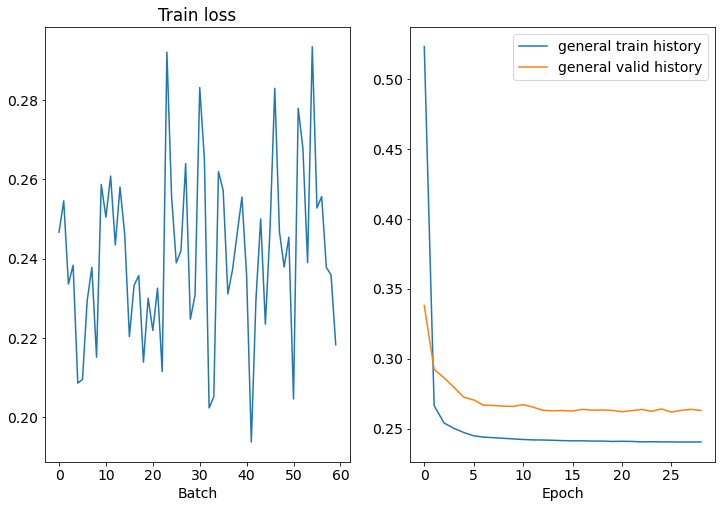

Epoch: 30 | Time: 0m 28s
	Train Loss: 0.240 | Train PPL:   1.272
	 Val. Loss: 0.264 |  Val. PPL:   1.303


In [ ]:
N_EPOCHS = 30
CLIP = 1

model_train(False, N_EPOCHS, CLIP, lr=1e-5)

#### Последняя модель

In [ ]:
# top_k = 3
inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: в конце 2019 года все больше россиян стали экономить — причем практически на всем . они сокращали траты на покупку одежды и бытовой техники , развлечения . даже старались реже пользоваться личным автомобилем , поскольку это затратно . по итогам прошлого года доходы наших соотечественников выросли всего на 0,8 % . и в этом году надеяться особо не на что , предупреждают эксперты .
Hyp: россияне все чаще стараются экономить , показал квартальный опрос . в том , что приходится ужиматься в тратах , признались 70 % респондентов . глобальное исследование потребительского доверия the conference board проводилось совместно с nielsen .
BLEU:  0.4483358093852308
ROUGE:  {'rouge-1': {'f': 0.3173318124753693, 'p': 0.3031341514395032, 'r': 0.3531967563454291}, 'rouge-2': {'f': 0.1427732219026843, 'p': 0.1347593218711488, 'r': 0.16339726182715184}, 'rouge-l': {'f': 0.2715462303275745, 'p': 0.2739258120398613, 'r': 0.3186041265424389}}


In [ ]:
# logits > 0
inference_summarunner(model, test_iterator, pos_logits=True)

Count: 256
Ref: почти 80 % россиян считают важными предложенные президентом поправки к конституции . по опросу вциом , наибольшей поддержкой пользуются социальные инициативы главы государства — их одобрили более 90 % респондентов . кроме того , россияне положительно оценивают ужесточение требований к кандидатам в президенты , а также усиление роли парламента .
Hyp: большинство жителей россии считают важными поправки к конституции , предложенные президентом рф владимиром путиным .
BLEU:  0.20568676878841072
ROUGE:  {'rouge-1': {'f': 0.28581308697226854, 'p': 0.45919778514921167, 'r': 0.219641188273818}, 'rouge-2': {'f': 0.13981205894644846, 'p': 0.23760900955248368, 'r': 0.10636320899247398}, 'rouge-l': {'f': 0.21063508014696314, 'p': 0.4098455077843831, 'r': 0.19501514086226315}}


#### Лучшая модель

In [ ]:
model.load_state_dict(torch.load('best-val-model.pt'))

<All keys matched successfully>

In [ ]:
# top_k = 3
inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: около 1000 американских военных перебросят из сирии в западный ирак , заявил глава пентагона марк эспер . по его словам , там военные продолжат операции против исламских террористов и « помогут защищать страну » .
Hyp: « вывод [ войск ] из северо-восточной сирии проходит в быстром темпе , речь идет о неделях , а не днях . сейчас план действий сводится к переброске сил в западный ирак » , – подчеркнул эспер . 14 октября министр обороны сша признался в интервью fox news , что американские военнослужащие в сирии попали в ловушку .
BLEU:  0.4483358093852308
ROUGE:  {'rouge-1': {'f': 0.31733181247536874, 'p': 0.30313415143950334, 'r': 0.3531967563454292}, 'rouge-2': {'f': 0.1427732219026844, 'p': 0.13475932187114895, 'r': 0.16339726182715167}, 'rouge-l': {'f': 0.2715462303275747, 'p': 0.2739258120398611, 'r': 0.3186041265424389}}


In [ ]:
# logits > 0
inference_summarunner(model, test_iterator, pos_logits=True)

Count: 256
Ref: украинская певица светлана лобода подверглась критике в instagram из-за жалобы на напряженный рабочий график и стертые от танцев ноги . фотография мозоли на стопе артистки вызвала бурную реакцию подписчиков , которые посоветовали ей сравнить свою высокооплачиваемую работу на сцене с условиями на стройке или в шахте .
Hyp: подписчики заслуженной артистки украины светланы лободы раскритиковали ее за жалобу на напряженный рабочий график и стертые от интенсивных танцев ноги .
BLEU:  0.20568676878841072
ROUGE:  {'rouge-1': {'f': 0.28581308697226865, 'p': 0.45919778514921156, 'r': 0.21964118827381793}, 'rouge-2': {'f': 0.13981205894644852, 'p': 0.23760900955248376, 'r': 0.10636320899247392}, 'rouge-l': {'f': 0.21063508014696303, 'p': 0.4098455077843829, 'r': 0.19501514086226315}}


### 3. Без novelty, с весами

In [ ]:
vocab_size = len(vocabulary)
model = SentenceTaggerRNN(vocab_size, use_novelty=False).to(device)

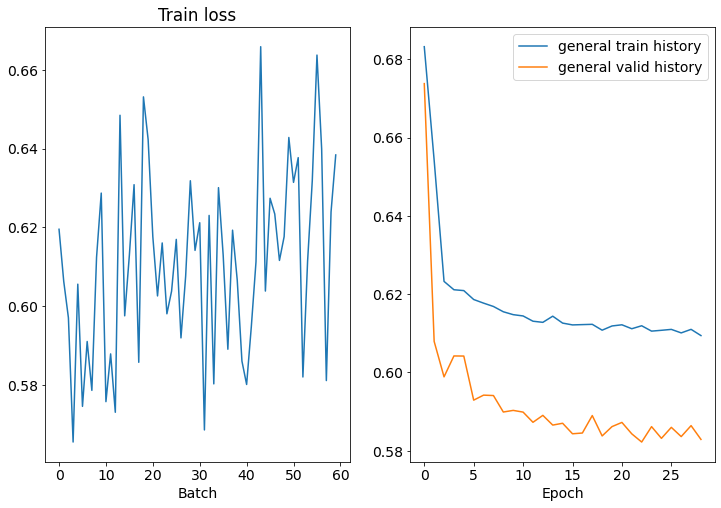

Epoch: 30 | Time: 0m 28s
	Train Loss: 0.611 | Train PPL:   1.842
	 Val. Loss: 0.584 |  Val. PPL:   1.793


In [ ]:
N_EPOCHS = 30
CLIP = 1

model_train(True, N_EPOCHS, CLIP, lr=1e-5)

#### Последняя модель

In [ ]:
# top_k = 3
inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: международный союз биатлонистов ( ibu ) аннулировал результат сборной норвегии в смешанной эстафете чемпионата европы после протеста команды белоруссии , в котором говорилось , что финишер скандинавов александр андерсен наступил на лыжу сергею бочарникову , а затем вытолкнул его с трассы . это позволило белорусам получить бронзовые медали , однако спустя несколько часов жюри резко изменило свое мнение и вернуло норвежцам награды .
Hyp: в белорусских раубичах в самом разгаре чемпионат европы по биатлону . этот турнир , как правило , проходит без таких страстей , как чемпионат мира , поскольку изрядно уступает ему по статусу , и даже наличие множества топовых сборных , вроде норвегии , швеции и россии , не спасает — все они отправляют на евро не свою основную команду , а молодежь , которой только предстоит зарекомендовать себя . первый день чемпионата европы прошел в привычном режиме , а спокойствие нарушали лишь критические отзывы биатлонистов о качестве трассы , которую

In [ ]:
# logits > 0
inference_summarunner(model, test_iterator, pos_logits=True)

Count: 256
Ref: министр обороны сша марк эспер заявил , что американские военные будут защищать сирийские месторождения нефти . вашингтон намерен обороняться от « любых сил , которые будут ему угрожать » , в том числе от россии и сирийских военных .
Hyp: военнослужащие сша продолжат защищать нефтяные месторождения на севере сирии , заявил глава пентагона марк эспер . « сша будут поддерживать контроль над нефтяными месторождениями на северо-востоке сирии ... вооруженные силы сша будут давать серьезный ответ любым силам , которые будут им угрожать » , — обратил он внимание во время пресс-конференции , которая транслировалась в twitter оборонного ведомства . на вопрос , намерены ли американские солдаты не допускать на нефтяные месторождения также россию и сирийских военных , эспер ответил : « в целом да » . по его словам , основная цель американских военных — передать эти месторождения союзным им курдским формированиям « сирийских демократических сил » ( sdf ) . глава минобороны сша отмет

#### Лучшая модель

In [ ]:
model.load_state_dict(torch.load('best-val-model.pt'))

<All keys matched successfully>

In [ ]:
# top_k = 3
inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: жителей миасса возмутило хвастовство мэра города григория тонких — чиновник опубликовал пост , в котором рассказал , как по его требованию в местной школе № 23 дыры , которые ученики использовали в качестве туалетов , заменили на нормальные унитазы . на приложенном к новости снимке нового санузла видно , что между унитазами нет никакой перегородки — миассцы назвали это позором . при этом директор учебного заведения уверила , что кабины еще установят , а мэр « немного поторопился » с новостью .
Hyp: мэр миасса григорий тонких похвастался в своем instagram ремонтом туалетов в школе № 23 , расположенной в поселке северные печи . по словам чиновника , в конце 2019 года он пришел с визитом в учреждение и увидел дырки в полу вместо стандартных туалетов – после этого глава города велел сотрудникам управления образования администрации округа отремонтировать санузел . « средства были изысканы , и на сегодняшний день в туалете установлены четыре новых унитаза .
BLEU:  0.448335809

In [ ]:
# logits > 0
inference_summarunner(model, test_iterator, pos_logits=True)

Count: 256
Ref: басманный суд москвы арестовал на два месяца начальника управления таможенного дознания федеральной таможенной службы ( фтс ) генерал-лейтенанта александра кизлыка . по данным следствия , в ходе обысков у него изъяли коллекцию драгоценностей , золотые слитки и около 80 млн рублей наличными . сам генерал-лейтенант не признает себя виновным и отрицает , что за деньги помогал избегать ответственности контрабандистам .
Hyp: в ходе обысков у начальника управления таможенного дознания федеральной таможенной службы ( фтс ) генерал-лейтенанта александра кизлыка изъяли € 600 тыс . и $ 600 тыс . ( всего около 80 млн руб . ) , а также золотые слитки , коллекцию швейцарских часов и другие драгоценности . об этом сообщил следователь скр дмитрий аверьянов , выступая на слушании в басманном суде , где 24 декабря фигуранту дела избиралась мера пресечения . кизлыку предъявлены обвинения по двум эпизодам злоупотребления должностными полномочиями ( ст . 285 ук рф ) . как считает следствие

### 4. С novelty, без весов

In [ ]:
vocab_size = len(vocabulary)
model = SentenceTaggerRNN(vocab_size, use_novelty=True).to(device)

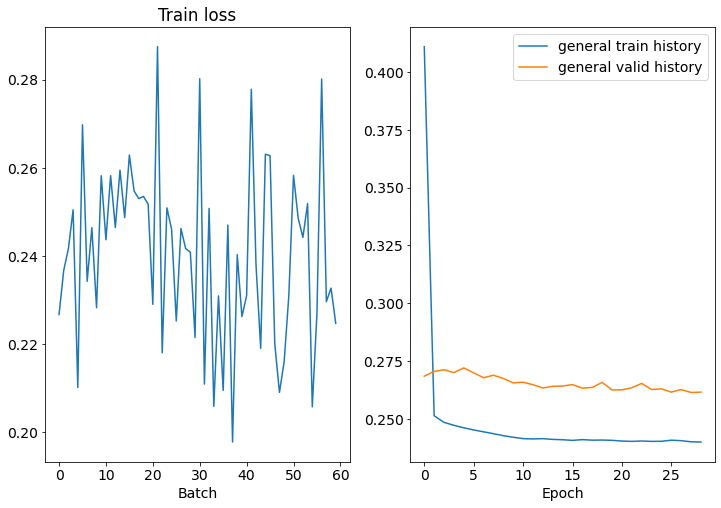

Epoch: 30 | Time: 0m 29s
	Train Loss: 0.240 | Train PPL:   1.271
	 Val. Loss: 0.262 |  Val. PPL:   1.299


In [ ]:
N_EPOCHS = 30
CLIP = 1

model_train(False, N_EPOCHS, CLIP, lr=1e-5)

#### Последняя модель

In [ ]:
# top_k = 3
inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: осло нарушает договор об архипелаге шпицберген от 9 февраля 1920 года , заявило посольство рф в норвегии . по мнению москвы , осло ограничивает права российских компаний на доступ к минеральным ресурсам , а также на разработку углеводородных месторождений . посольство также напомнило , что шпицберген не является « исконно норвежской территорией » .
Hyp: как указывается в сообщении в facebook посольства рф в норвегии , москва лишена возможности участвовать в подаче заявок на некоторые перспективные участки по энергоносителям . « российская сторона расценивает вынесение на раунды по распределению лицензий на разработку нефтегазовых ресурсов континентального шельфа участков , расположенных в пределах действия договора , как нарушающее обязательства норвегии » , — указывает диппредставительство . посольство уточнило , что не ставит под сомнение норвежский суверенитет над архипелагом , но напомнило , что шпицберген не является « исконно норвежской территорией » и был получен

In [ ]:
# logits > 0
inference_summarunner(model, test_iterator, pos_logits=True)

Count: 256
Ref: актер сериала « улицы разбитых фонарей » виталий жигалин скончался на 49-м году жизни после продолжительной болезни . трагическую новость сообщили коллеги артиста из самарского академического театра драмы имени максима горького , в котором он прослужил почти 25 лет .
Hyp: российский актер и театральный педагог виталий жигалин ушел из жизни в возрасте 48 лет после продолжительной болезни .
BLEU:  0.20568676878841072
ROUGE:  {'rouge-1': {'f': 0.2858130869722686, 'p': 0.45919778514921183, 'r': 0.21964118827381798}, 'rouge-2': {'f': 0.13981205894644846, 'p': 0.2376090095524837, 'r': 0.10636320899247405}, 'rouge-l': {'f': 0.2106350801469631, 'p': 0.40984550778438306, 'r': 0.19501514086226324}}


#### Лучшая модель

In [ ]:
model.load_state_dict(torch.load('best-val-model.pt'))

<All keys matched successfully>

In [ ]:
# top_k = 3
inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: в мхате им . горького опровергли информацию , согласно которой президент театра татьяна доронина в настоящее время находится в больнице . ранее об этом заявил актер андрей чубченко — по его словам , народная артистка ссср « испытывает огромный шок » из-за происходящего во мхате .
Hyp: пресс-секретарь мхата им . горького наталья федотова опровергла распространившуюся в сми информацию о том , что президент театра татьяна доронина в настоящее время находится в больнице . по ее словам , народная артистка ссср недавно действительно обращалась ко врачам , однако происходило это в плановом порядке — в рамках подготовки актрисы к церемонии вручения госнаград в кремле , которая прошла 21 ноября . « нет , [ она не в больнице ] .
BLEU:  0.4483358093852308
ROUGE:  {'rouge-1': {'f': 0.31733181247536896, 'p': 0.3031341514395032, 'r': 0.35319675634542896}, 'rouge-2': {'f': 0.14277322190268438, 'p': 0.13475932187114895, 'r': 0.16339726182715175}, 'rouge-l': {'f': 0.27154623032757497, '

In [ ]:
# logits > 0
inference_summarunner(model, test_iterator, pos_logits=True)

Count: 256
Ref: посольство россии в париже просит французские власти разобраться в ситуации с российскими туристами , застрявшими на круизном лайнере возле марселя . по словам представителя мид рф марии захаровой , на борту находятся 35 россиян и 4 белоруса . французы несколько дней не разрешают им сойти на берег .
Hyp: ноту с просьбой разрешить ситуацию с российскими туристами направило посольство россии в париже министерству иностранных дел франции .
BLEU:  0.20568676878841072
ROUGE:  {'rouge-1': {'f': 0.2858130869722688, 'p': 0.4591977851492118, 'r': 0.2196411882738179}, 'rouge-2': {'f': 0.13981205894644855, 'p': 0.2376090095524836, 'r': 0.10636320899247399}, 'rouge-l': {'f': 0.21063508014696308, 'p': 0.4098455077843833, 'r': 0.19501514086226307}}


### 5. С novelty, с весами

In [ ]:
vocab_size = len(vocabulary)
model = SentenceTaggerRNN(vocab_size, use_novelty=True).to(device)

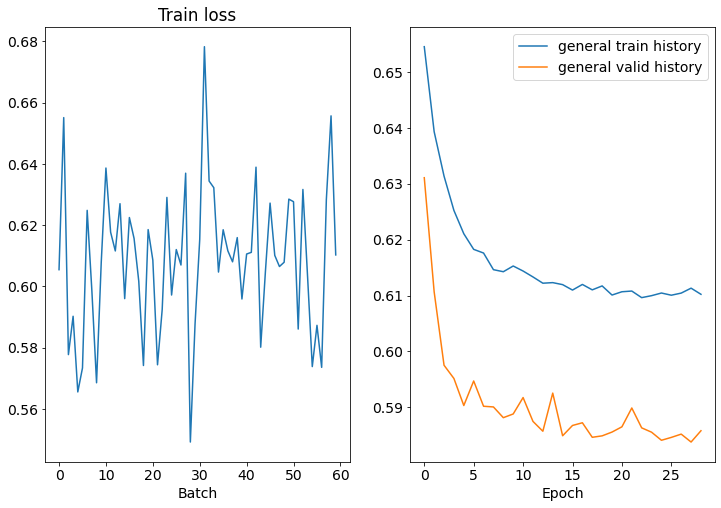

Epoch: 30 | Time: 0m 29s
	Train Loss: 0.610 | Train PPL:   1.840
	 Val. Loss: 0.587 |  Val. PPL:   1.798


In [ ]:
N_EPOCHS = 30
CLIP = 1

model_train(True, N_EPOCHS, CLIP, lr=1e-5)

#### Последняя модель

In [ ]:
# top_k = 3
inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: госдума приняла во втором чтении законопроект о поддержке отечественных производителей вина . задача депутатов — поддержать добросовестных виноделов и наказать тех , кто производит вино из низкосортных импортных виноматериалов . это сложнейшая задача для законодателя , поскольку и те , кто работает добросовестно , и те , кто выпускает алкоголь сомнительного качества , считаются отечественными производителями .
Hyp: во вторник , 17 декабря , госдума приняла во втором чтении законопроект о продлении до 1 января 2023 года переходного периода для крымских виноделов . законопроект устанавливает особенности производства и оборота этилового спирта , алкогольной и спиртосодержащей продукции в крыму и севастополе . крымские производители спиртного будут обязаны до указанной даты оснастить технологическое оборудование приборами измерения и учета готовой продукции и оформить в собственность или в аренду производственные мощности для изготовления вина .
BLEU:  0.4483358093852308
RO

In [ ]:
# logits > 0
inference_summarunner(model, test_iterator, pos_logits=True)

Count: 256
Ref: владимир путин призвал свести к минимуму возможность умаления прав человека в новых законах . по его словам , законопроекты должны соответствовать мировым стандартам в сфере прав и свобод человека . кроме того , президент отметил важную роль конституционного суда как надежного хранителя конституционного порядка .
Hyp: президент россии владимир путин призвал российских законодателей не отступать от мировых стандартов в сфере прав и свобод человека при принятии новых законов . по его словам , закон — это практически всегда компромисс интересов . « важно , чтобы законодатели не отступали от общепризнанных мировых стандартов в сфере защиты прав и свобод человека » , — сказал путин на встрече с судьями конституционного суда россии . декларирование прав в конституции « не означает , к сожалению , на практике их соблюдение » , добавил президент , необходимы соответствующие механизмы , чтобы свести к минимуму « вероятность умаления прав и их отрицания » . кроме того , путин отм

#### Лучшая модель

In [ ]:
model.load_state_dict(torch.load('best-val-model.pt'))

<All keys matched successfully>

In [ ]:
# top_k = 3
inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: в tiktok запущен челлендж , получивший название « skull-breaker challenge » — двое людей заставляют третьего подпрыгнуть , а затем , пока он находится в прыжке , выбивают ему ноги , чтобы тот упал навзничь . после этого пранка несколько подростков были госпитализированы с травмами разной тяжести , а американские власти уже возбудили как минимум одно уголовное дело против несовершеннолетних , ставших авторами одного из подобных видеороликов .
Hyp: в социальной сети tiktok запустился опасный челлендж , который может представлять угрозу для здоровья , сообщает washington post . его суть заключается в том , что двое людей становятся с обеих сторон своей жертвы , предлагая ей подпрыгнуть вверх . пока она находится в прыжке , ей выбивают ноги таким образом , что она падает и приземляется на спину .
BLEU:  0.4483358093852308
ROUGE:  {'rouge-1': {'f': 0.31733181247536885, 'p': 0.3031341514395034, 'r': 0.3531967563454289}, 'rouge-2': {'f': 0.14277322190268435, 'p': 0.13475932187

In [ ]:
# logits > 0
inference_summarunner(model, test_iterator, pos_logits=True)

Count: 256
Ref: актер маколей калкин рассказал о своих отношениях с певцом майклом джексоном , многократно обвиненным в педофилии . по словам звезды фильма « один дома » , в последний раз он виделся с артистом в 2005 году , когда тот был ответчиком на слушании дела о совращении 13-летнего мальчика . по словам калкина , во время перерыва в заседании они с джексоном обнялись .
Hyp: звезда рождественского суперхита « один дома » маколей калкин рассказал о своих отношениях с легендарным поп-исполнителем майклом джексоном . их последняя встреча состоялась в 2005 году во время слушания дела о предполагаемом совращении музыкантом 13-летнего мальчика . в интервью esquire калкин признался , что во время перерыва в судебном заседании он по-дружески обнял актера . « он никогда ничего со мной не делал , — заявил калкин . — я никогда не видел , чтобы он делал что-то неприемлемое .
BLEU:  0.3012117996070857
ROUGE:  {'rouge-1': {'f': 0.29824027302292233, 'p': 0.23107405500805286, 'r': 0.4545034163062

## Вывод:

Сгруппируем все результаты

In [ ]:
import pandas as pd

index = ['novelty=True, weights=False, train=False',
         'novelty=False, weights=False, last_model',
         'novelty=False, weights=False, best_model',

         'novelty=False, weights=True, last_model',
         'novelty=False, weights=True, best_model',

         'novelty=True, weights=False, last_model',
         'novelty=True, weights=False, best_model',

         'novelty=True, weights=True, last_model',
         'novelty=True, weights=True, best_model'
         ]

columns = ['novelty', 'weights', 'bleu', 'rouge_1', 'rouge_2', 'rouge_l']

# for top-3
top_data = [(True, False, 0.448, 0.317, 0.143, 0.272),
            (False, False, 0.448, 0.317, 0.143, 0.272),
            (False, False, 0.448, 0.317, 0.143, 0.272),
            (False, True, 0.448, 0.317, 0.143, 0.272),
            (False, True, 0.448, 0.317, 0.143, 0.272),
            (True, False, 0.448, 0.317, 0.143, 0.272),
            (True, False, 0.448, 0.317, 0.143, 0.272),
            (True, True, 0.448, 0.317, 0.143, 0.272),
            (True, True, 0.448, 0.317, 0.143, 0.272)
            ]


# for logits > 0
logits_data = [(True, False, 0.353, 0.310, 0.135, 0.250),
               (False, False, 0.206, 0.286, 0.140, 0.211),
               (False, False, 0.206, 0.286, 0.140, 0.211),
               (False, True, 0.305, 0.298, 0.127, 0.227),
               (False, True, 0.281, 0.291, 0.124, 0.216),
               (True, False, 0.206, 0.286, 0.140, 0.211),
               (True, False, 0.206, 0.286, 0.140, 0.211),
               (True, True, 0.331, 0.308, 0.135, 0.244),
               (True, True, 0.301, 0.298, 0.129, 0.229)
              ]

top_df = pd.DataFrame.from_records(data=top_data, index=index, columns=columns)
logit_df = pd.DataFrame.from_records(data=logits_data, index=index, columns=columns)

In [ ]:
# Статистика по метрикам, рассчитанным на top_k=3
top_df

,novelty,weights,bleu,rouge_1,rouge_2,rouge_l
"novelty=True, weights=False, train=False",True,False,0.448,0.317,0.143,0.272
"novelty=False, weights=False, last_model",False,False,0.448,0.317,0.143,0.272
"novelty=False, weights=False, best_model",False,False,0.448,0.317,0.143,0.272
"novelty=False, weights=True, last_model",False,True,0.448,0.317,0.143,0.272
"novelty=False, weights=True, best_model",False,True,0.448,0.317,0.143,0.272
"novelty=True, weights=False, last_model",True,False,0.448,0.317,0.143,0.272
"novelty=True, weights=False, best_model",True,False,0.448,0.317,0.143,0.272
"novelty=True, weights=True, last_model",True,True,0.448,0.317,0.143,0.272
"novelty=True, weights=True, best_model",True,True,0.448,0.317,0.143,0.272


Метрики, рассчитанные по top-3 предложениям идентичны для всех моделей, включая модель, инициализированную случайными весами (без обучения). По этим метрикам нельзя сказать, какая модель лучше.

In [ ]:
# Статистика по метрикам, рассчитанным на pos_logits > 0
logit_df

,novelty,weights,bleu,rouge_1,rouge_2,rouge_l
"novelty=True, weights=False, train=False",True,False,0.353,0.310,0.135,0.250
"novelty=False, weights=False, last_model",False,False,0.206,0.286,0.140,0.211
"novelty=False, weights=False, best_model",False,False,0.206,0.286,0.140,0.211
"novelty=False, weights=True, last_model",False,True,0.305,0.298,0.127,0.227
"novelty=False, weights=True, best_model",False,True,0.281,0.291,0.124,0.216
"novelty=True, weights=False, last_model",True,False,0.206,0.286,0.140,0.211
"novelty=True, weights=False, best_model",True,False,0.206,0.286,0.140,0.211
"novelty=True, weights=True, last_model",True,True,0.331,0.308,0.135,0.244
"novelty=True, weights=True, best_model",True,True,0.301,0.298,0.129,0.229


In [ ]:
logit_df.sort_values(['bleu', 'rouge_1'], ascending=False)

,novelty,weights,bleu,rouge_1,rouge_2,rouge_l
"novelty=True, weights=False, train=False",True,False,0.353,0.310,0.135,0.250
"novelty=True, weights=True, last_model",True,True,0.331,0.308,0.135,0.244
"novelty=False, weights=True, last_model",False,True,0.305,0.298,0.127,0.227
"novelty=True, weights=True, best_model",True,True,0.301,0.298,0.129,0.229
"novelty=False, weights=True, best_model",False,True,0.281,0.291,0.124,0.216
"novelty=False, weights=False, last_model",False,False,0.206,0.286,0.140,0.211
"novelty=False, weights=False, best_model",False,False,0.206,0.286,0.140,0.211
"novelty=True, weights=False, last_model",True,False,0.206,0.286,0.140,0.211
"novelty=True, weights=False, best_model",True,False,0.206,0.286,0.140,0.211


* Лучший результат имеет модель со случайными весами.
* Если не принимать во внимание случайную инициализацию, то более высокое качество достигается с использованием весов классов в функции ошибки и использования novelty.
* Качество модели в сравнении с семинаром не удалось улучшить (и даже повторить).
* Кроме представленного в данном ноутбуке решения, были опробованы следующие подходы и их различные комбинации:
  - Изменение learnining rate. При меньших значениях модель переобучалась и показывала хуже результаты при инференсе на положительных логитах (качество на top_k часто оставалось таким же, как и в текущем исполнении).
  - Изменение количества эпох обучения не повлияло на качество. 5 эпох достаточно.
  - Изменение максимальной длины предложения не повлияло на результат.
  - Изменение параметров модели - увеличение размера эмбеддингов, и размеров hidden_size, изменение dropout - не влияли на качество модели (было несколько интераций с разными параметрами).
  - Изменение logits > 0 на torch.sigmoid(logits) > threshold отрицательно сказались на метриках инференса на логитах. Порог от 0.7 показывал bleu $\approx$ 0.2. Понижение порога значительно снижало bleu, повышение порога не влияло на bleu.
  - Была гипотеза, что каким-то образом, на инференсе всегда используется одна и та же модель. Я переписала функции обучения, чтобы они явно принимали модель и возвращали обученную модель, и удаляла сохраненные веса лучшей модели перед каждым экспериментом. На результаты это не повлияло, поэтому данные "улучшения" не попали в текущую версию исполнения.
* Субьективно, все модели показывают хорошие результаты. На мой взгляд, предложения, подобранные для summary, выглядят адекватно. Данный подход (архитектура модели) может быть использована для задачи summarization.